In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Load Data

Note: Change the path to the folder containing dataset

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/GAN/Data/DATA.xlsx', parse_dates=['Date'])
df = df.dropna(how = 'all', axis =1)
df = df.dropna(how = 'all')
df.head()

,Date,Open,High,Low,Close,Volume,NASDAQ,NYSE,S&P 500,NIKKI225,RUSSELL2000,SSE,GC=F,VIX,USD index,Amazon,Google,Microsoft,Dow,Wilshire 5000,Apple,TNX
0,2011-01-03,3.8800,3.9925,3.8750,3.9550,81744800,2691.520020,8043.970215,1271.87,NaN,798.559998,NaN,1422.599976,17.610001,79.13,184.220001,184.220001,27.98,11670.75,13519.150391,11.770357,3.342
1,2011-01-04,3.9625,3.9800,3.8550,3.9425,65138400,2681.250000,8022.180176,1270.20,10398.09961,785.830017,2852.647949,1378.500000,17.379999,79.44,185.009995,185.009995,28.09,11691.18,13474.370117,11.831786,3.346
2,2011-01-05,4.0150,4.2500,3.9750,4.2450,142821600,2702.199951,8040.040039,1276.56,10380.76953,795.090027,2839.220947,1373.400024,17.020000,80.26,187.419998,187.419998,28.00,11722.89,13554.179688,11.928571,3.483
3,2011-01-06,4.3550,4.8350,4.3425,4.8325,349331200,2709.889893,8000.899902,1273.85,10529.75977,791.419983,2824.197021,1371.400024,17.400000,80.79,185.860001,185.860001,28.82,11697.31,13526.089844,11.918929,3.419
4,2011-01-07,4.7775,4.9825,4.6700,4.9675,257998400,2703.169922,7980.319824,1271.50,10541.04004,787.830017,2838.801025,1368.500000,17.139999,81.01,185.490005,185.490005,28.60,11674.76,13501.110352,12.004286,3.328


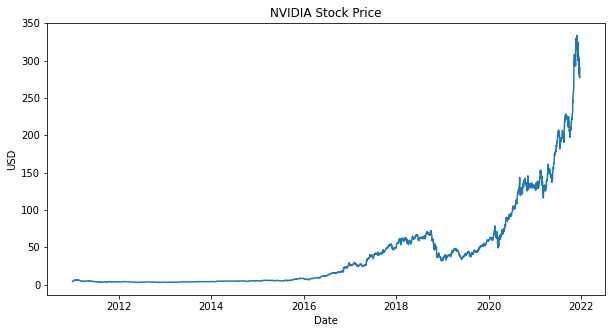

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['Date'], df['Close'])
ax.set(xlabel="Date", ylabel="USD", title="NVIDIA Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

##Calculate Common Technical Indiators

In [ ]:
def get_technical_indicators(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [ ]:
T_df = get_technical_indicators(df)
dataset = T_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Volume,NASDAQ,NYSE,S&P 500,NIKKI225,RUSSELL2000,SSE,GC=F,VIX,USD index,Amazon,Google,Microsoft,Dow,Wilshire 5000,Apple,TNX,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2011-02-01,6.0325,6.1625,5.9925,6.1175,65410400,2751.189941,8290.089844,1307.59,10274.50000,798.890015,2798.959961,1339.599976,17.629999,77.07,172.110001,172.110001,27.990000,12040.16,13848.099609,12.322500,3.443,6.066429,5.539750,-0.097551,0.639807,6.819364,4.260136,6.073411,1.632666
1,2011-02-02,6.0825,6.5425,6.0825,6.3950,160661600,2749.560059,8272.570313,1304.03,10457.36035,796.159973,NaN,1331.500000,17.299999,77.16,173.529999,173.529999,27.940001,12041.97,13812.250000,12.297143,3.489,6.096786,5.662375,-0.077732,0.545663,6.753701,4.571049,6.287804,1.685473
2,2011-02-03,6.4050,6.4050,6.1375,6.2750,103077600,2753.879883,8289.049805,1307.10,10431.36035,798.630005,NaN,1352.300049,16.690001,77.75,173.710007,173.710007,27.650000,12062.26,13846.629883,12.265714,3.541,6.137143,5.763875,-0.118293,0.448244,6.660363,4.867387,6.279268,1.662979
3,2011-02-04,6.3625,6.4675,6.3375,6.4175,87290000,2769.300049,8288.500000,1310.87,10543.51953,800.109985,NaN,1348.300049,15.930000,78.04,175.929993,175.929993,27.770000,12092.15,13882.450195,12.375000,3.652,6.177500,5.843125,-0.131254,0.413692,6.670510,5.015740,6.371423,1.689634
4,2011-02-07,6.3300,6.3575,6.1275,6.1500,93423600,2783.989990,8336.639648,1319.05,10592.04004,808.320007,NaN,1347.599976,16.280001,78.03,176.429993,176.429993,28.200001,12161.63,13979.110352,12.567143,3.644,6.182143,5.902250,-0.157598,0.363407,6.629063,5.175437,6.223808,1.638997


In [ ]:
def plot_technical_indicators(dataset):
       fig,ax = plt.subplots(figsize=(8, 5), dpi = 200)
       x_ = range(3, dataset.shape[0])
       x_ = list(dataset.index)

       ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
       ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='b')
       ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='--')
       ax.plot(dataset['Date'], dataset['upper_band'], label='Upper Bollinger Band', color='c')
       ax.plot(dataset['Date'], dataset['lower_band'], label='Lower Bollinger Band', color='c')
       ax.fill_between(dataset['Date'], dataset['lower_band'], dataset['upper_band'], alpha=0.35)
       ax.xaxis.set_major_formatter(DateFormatter("%Y"))
       plt.title('Technical indicators')
       plt.ylabel('USD')
       plt.xlabel("Year")
       plt.legend()

       plt.show()

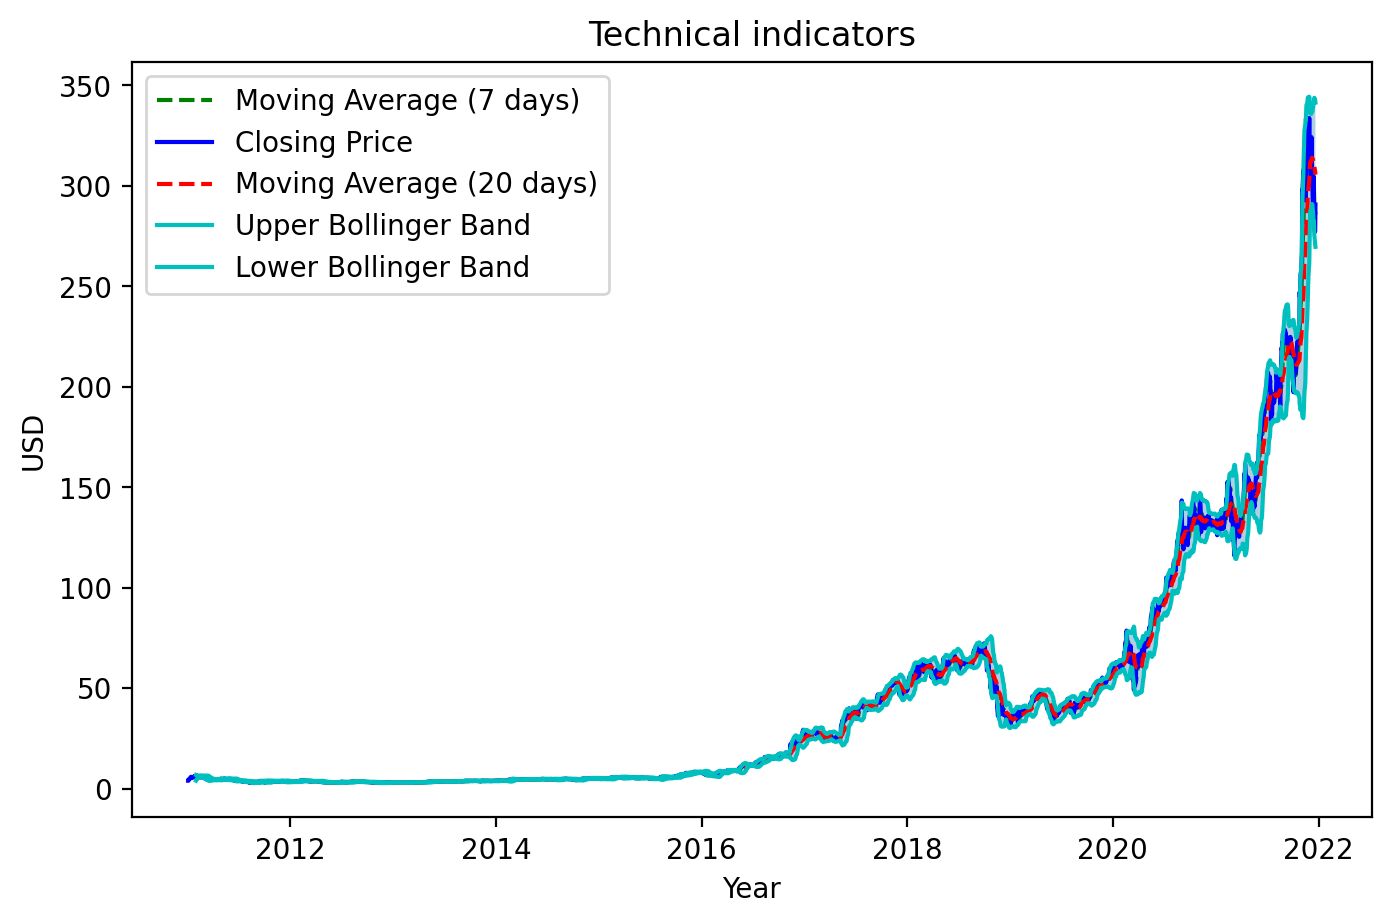

In [ ]:
plot_technical_indicators(T_df)

In [ ]:
dataset.to_excel('/content/drive/MyDrive/GAN/Calculated Data/Calculated_Data.xlsx', index=False)

In [ ]:
dataset = pd.read_excel('/content/drive/MyDrive/GAN/Calculated Data/Calculated_Data.xlsx')

Fill all empty values with the closest value from the past

In [ ]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [ ]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

Normalize the data 

In [ ]:
def data_normalization(df, range, target_column):

  '''
  df: dataframe object
  range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
  target_column: type str -> should reflect closing price of stock
  '''

  target_df_series = pd.DataFrame(df[target_column])
  data = pd.DataFrame(df.iloc[:, :])
  
  X_scaler = MinMaxScaler(feature_range=range)
  y_scaler = MinMaxScaler(feature_range=range)
  X_scaler.fit(data)
  y_scaler.fit(target_df_series)

  X_scale_dataset = X_scaler.fit_transform(data)
  y_scale_dataset = y_scaler.fit_transform(target_df_series)

  dump(X_scaler, open('/content/X_scaler.pkl', 'wb'))
  dump(y_scaler, open('/content/y_scaler.pkl', 'wb'))

  return (X_scale_dataset,y_scale_dataset)

In [ ]:
def batch_data(x_data,y_data, batch_size, predict_period):
  X_batched, y_batched, yc = list(), list(), list()

  for i in range(0,len(x_data),1):
    x_value = x_data[i: i + batch_size][:, :]
    y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
    yc_value = y_data[i: i + batch_size][:, :]
    if len(x_value) == batch_size and len(y_value) == predict_period:
      X_batched.append(x_value)
      y_batched.append(y_value)
      yc.append(yc_value)
  
  return np.array(X_batched), np.array(y_batched), np.array(yc)

In [ ]:
def split_train_test(data, split_ratio = 0.8):
    train_size = round(len(data) * split_ratio)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [ ]:
X_scale_dataset,y_scale_dataset = data_normalization(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (2737, 5, 29)
y shape: (2737, 1)
yc shape: (2737, 5, 1)


In [ ]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

##Model Architecture

In [ ]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = Sequential()
    model.add(GRU(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=768, return_sequences = True, recurrent_dropout=0.2)) 
    model.add(GRU(units=512, return_sequences = True,recurrent_dropout=0.2)) 
    model.add(GRU(units=256, recurrent_dropout=0.2)) 
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(units=output_dim))
    return model

In [ ]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(256, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

##Training Code

In [ ]:
def discriminator_loss(real_output, fake_output):
  loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  real_loss = loss_f(tf.ones_like(real_output), real_output)
  fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  loss = loss_f(tf.ones_like(fake_output), fake_output)
  return loss

In [ ]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_data = generator(real_x, training=True)
    generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
    d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
    real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
    d_real_input = tf.concat([real_y_reshape, yc], axis=1)

    real_output = discriminator(d_real_input, training=True)
    fake_output = discriminator(d_fake_input, training=True)

    g_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [ ]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 20):
  train_info = {}
  train_info["discriminator_loss"] = []
  train_info["generator_loss"] = []

  for epoch in tqdm(range(Epochs)):
    real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
    G_losses = []
    D_losses = []
    Real_price = []
    Predicted_price = []
    D_losses.append(loss['d_loss'].numpy())
    G_losses.append(loss['g_loss'].numpy())
    Predicted_price.append(fake_price.numpy())
    Real_price.append(real_price.numpy())

    #Save model every X checkpoints
    if (epoch + 1) % checkpoint == 0:
      tf.keras.models.save_model(generator, 'generator_V_%d.h5' % epoch)
      print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
    train_info["discriminator_loss"].append(D_losses)
    train_info["generator_loss"].append(G_losses)
  
  Predicted_price = np.array(Predicted_price)
  Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
  Real_price = np.array(Real_price)
  Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

  plt.subplot(2,1,1)
  plt.plot(train_info["discriminator_loss"], label='D_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Discriminator Loss')
  plt.legend()

  plt.subplot(2,1,2)
  plt.plot(train_info["generator_loss"], label='G_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Generator Loss')
  plt.legend()

  plt.show()

  return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

Plotting Training Results

In [ ]:
def plot_results(Real_price, Predicted_price, index_train):
  X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
  y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
  train_predict_index = index_train

  rescaled_Real_price = y_scaler.inverse_transform(Real_price)
  rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

  predict_result = pd.DataFrame()
  for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
  real_price = pd.DataFrame()
  for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
  real_price['real_mean'] = real_price.mean(axis=1)

  plt.figure(figsize=(16, 8))
  plt.plot(real_price["real_mean"])
  plt.plot(predict_result["predicted_mean"], color = 'r')
  plt.xlabel("Date")
  plt.ylabel("Stock price")
  plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
  plt.title("The result of Training", fontsize=20)
  plt.show()

  predicted = predict_result["predicted_mean"]
  real = real_price["real_mean"]
  For_MSE = pd.concat([predicted, real], axis = 1)
  RMSE = np.sqrt(mean_squared_error(predicted, real))
  print('-- Train RMSE -- ', RMSE)

#Test Code

In [ ]:
@tf.function 

def eval_op(generator, real_x):
  generated_data = generator(real_x, training = False)

  return generated_data

In [ ]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
  X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
  y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
  test_predict_index = index_test
  
  rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
  rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

  predict_result = pd.DataFrame()
  for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
  real_price = pd.DataFrame()
  for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
  real_price['real_mean'] = real_price.mean(axis=1)

  plt.figure(figsize=(16, 8))
  plt.plot(real_price["real_mean"])
  plt.plot(predict_result["predicted_mean"], color = 'r')
  plt.xlabel("Date")
  plt.ylabel("Stock price")
  plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
  plt.title("The result of Test Data", fontsize=20)
  plt.show()

  predicted = predict_result["predicted_mean"]
  real = real_price["real_mean"]
  For_MSE = pd.concat([predicted, real], axis = 1)
  RMSE = np.sqrt(mean_squared_error(predicted, real))
  print('-- Test RMSE -- ', RMSE)

#Hyper-parameter Tuning

Test 1

In [ ]:
learning_rate = 0.00016

g_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
 95%|█████████▌| 19/20 [04:21<00:13, 13.35s/it]

100%|██████████| 20/20 [04:37<00:00, 13.88s/it]

epoch 20 discriminator_loss 1.3783386 generator_loss 0.7028092


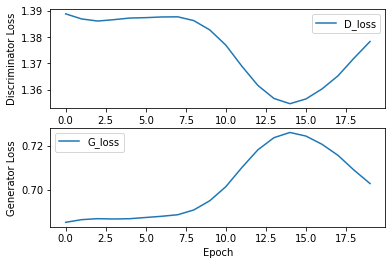

In [ ]:
Predicted_price, Real_price, RMSPE = train(X_train, y_train, yc_train, 20, generator, discriminator, g_optimizer, d_optimizer)

Refer to path defined in training code to load model

In [ ]:
test_generator = tf.keras.models.load_model('gen_model_3_1_19.h5')

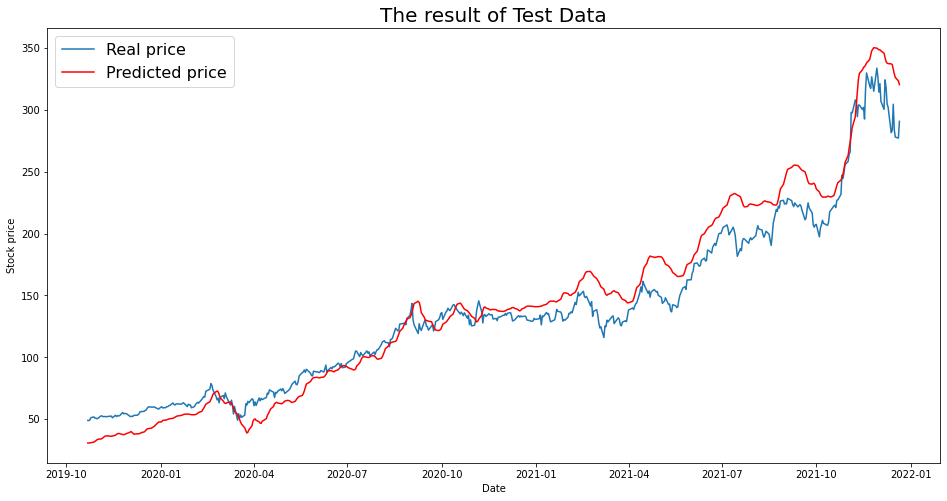

-- Test RMSE --  17.955666976164178


In [ ]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

Test 2 (Changing Model Architecture)

In [ ]:
def generator2(input_dim, output_dim, feature_size):
  model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.2),
                               LSTM(units = 768, return_sequences = True, recurrent_dropout = 0.2),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.2),
                               LSTM(units = 256, recurrent_dropout = 0.2),
                               Dense(128),
                               Dense(64),
                               Dense(32),
                               Dense(units=output_dim)])
  return model

In [ ]:
def discriminator2(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(256, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
 19%|█▉        | 19/100 [00:38<01:01,  1.32it/s]

 20%|██        | 20/100 [00:39<01:03,  1.26it/s]

epoch 20 discriminator_loss 1.4115939 generator_loss 0.6519126


 39%|███▉      | 39/100 [00:54<00:45,  1.33it/s]

 40%|████      | 40/100 [00:55<00:47,  1.27it/s]

epoch 40 discriminator_loss 1.3378203 generator_loss 0.7409441


 59%|█████▉    | 59/100 [01:09<00:31,  1.31it/s]

 60%|██████    | 60/100 [01:10<00:31,  1.26it/s]

epoch 60 discriminator_loss 1.358152 generator_loss 0.7225164


 79%|███████▉  | 79/100 [01:24<00:16,  1.30it/s]

 80%|████████  | 80/100 [01:25<00:16,  1.25it/s]

epoch 80 discriminator_loss 1.380684 generator_loss 0.7044604


 99%|█████████▉| 99/100 [01:40<00:00,  1.30it/s]

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]

epoch 100 discriminator_loss 1.3843975 generator_loss 0.6949662


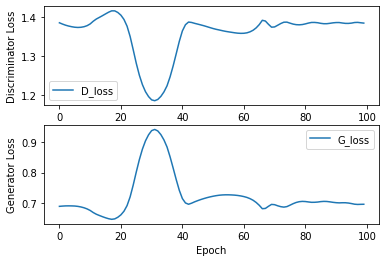

In [ ]:
learning_rate = 0.00016
g_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)

generator = generator2(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = discriminator2(X_train.shape[1])

Predicted_price, Real_price, RMSPE = train(X_train, y_train, yc_train, 100, generator, discriminator, g_optimizer, d_optimizer)

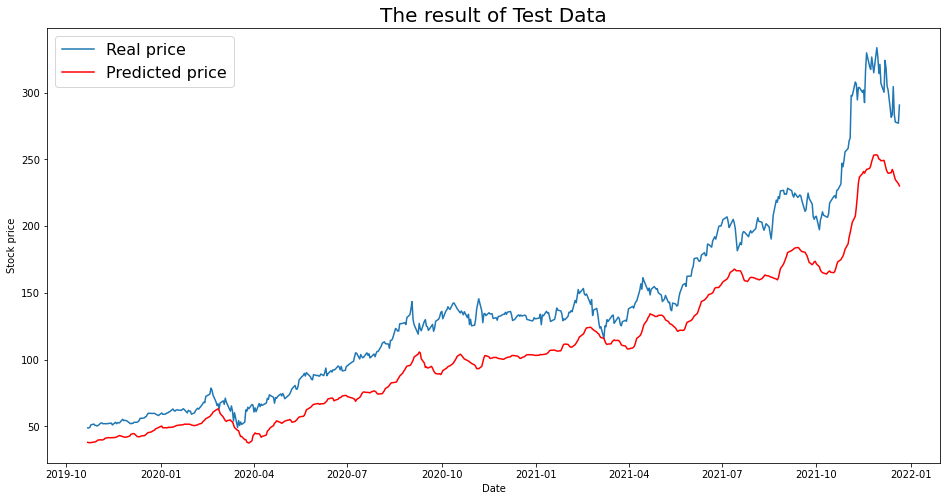

-- Test RMSE --  33.76255172638014


In [ ]:
LSTM_generator99 = tf.keras.models.load_model('gen_model_3_3_99.h5')
predicted_test_data = eval_op(LSTM_generator99, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

Test 3

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


  0%|          | 0/180 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
 11%|█         | 19/180 [00:27<01:40,  1.60it/s]

 11%|█         | 20/180 [00:28<01:44,  1.53it/s]

epoch 20 discriminator_loss 1.3941734 generator_loss 0.64433926


 22%|██▏       | 39/180 [00:40<01:27,  1.62it/s]

 22%|██▏       | 40/180 [00:40<01:29,  1.56it/s]

epoch 40 discriminator_loss 1.3857586 generator_loss 0.700069


 33%|███▎      | 59/180 [00:52<01:14,  1.62it/s]

 33%|███▎      | 60/180 [00:53<01:17,  1.55it/s]

epoch 60 discriminator_loss 1.3849616 generator_loss 0.7023886


 44%|████▍     | 79/180 [01:04<01:02,  1.62it/s]

 44%|████▍     | 80/180 [01:05<01:04,  1.56it/s]

epoch 80 discriminator_loss 1.3856409 generator_loss 0.69129944


 55%|█████▌    | 99/180 [01:17<00:50,  1.62it/s]

 56%|█████▌    | 100/180 [01:18<00:51,  1.55it/s]

epoch 100 discriminator_loss 1.3861451 generator_loss 0.6939153


 66%|██████▌   | 119/180 [01:29<00:37,  1.62it/s]

 67%|██████▋   | 120/180 [01:30<00:38,  1.55it/s]

epoch 120 discriminator_loss 1.3862025 generator_loss 0.69319326


 77%|███████▋  | 139/180 [01:42<00:25,  1.62it/s]

 78%|███████▊  | 140/180 [01:42<00:25,  1.55it/s]

epoch 140 discriminator_loss 1.3861606 generator_loss 0.6930381


 88%|████████▊ | 159/180 [01:54<00:12,  1.63it/s]

 89%|████████▉ | 160/180 [01:55<00:12,  1.55it/s]

epoch 160 discriminator_loss 1.386099 generator_loss 0.6933558


 99%|█████████▉| 179/180 [02:07<00:00,  1.62it/s]

100%|██████████| 180/180 [02:07<00:00,  1.41it/s]

epoch 180 discriminator_loss 1.386102 generator_loss 0.6931798


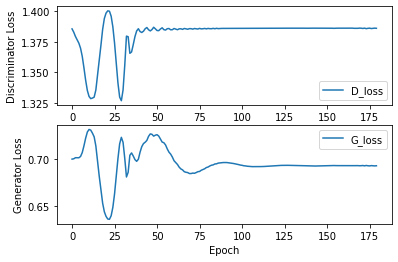

In [ ]:
learning_rate = 0.0002

g_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(input_dim)

Predicted_price, Real_price, RMSPE = train(X_train, y_train, yc_train, 180, generator, discriminator, g_optimizer, d_optimizer)

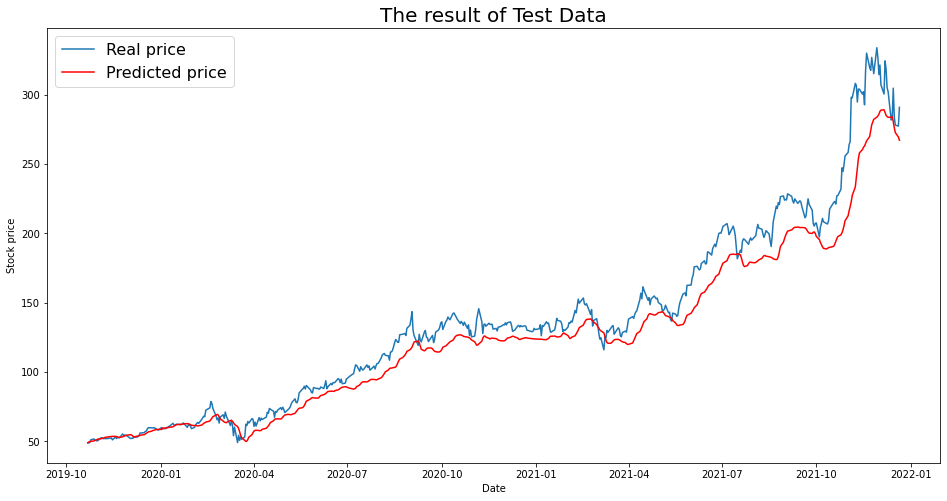

-- Test RMSE --  17.108520644900626


In [ ]:
test_generator159 = tf.keras.models.load_model('gen_model_3_5_159.h5')
predicted_test_data = eval_op(test_generator159, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

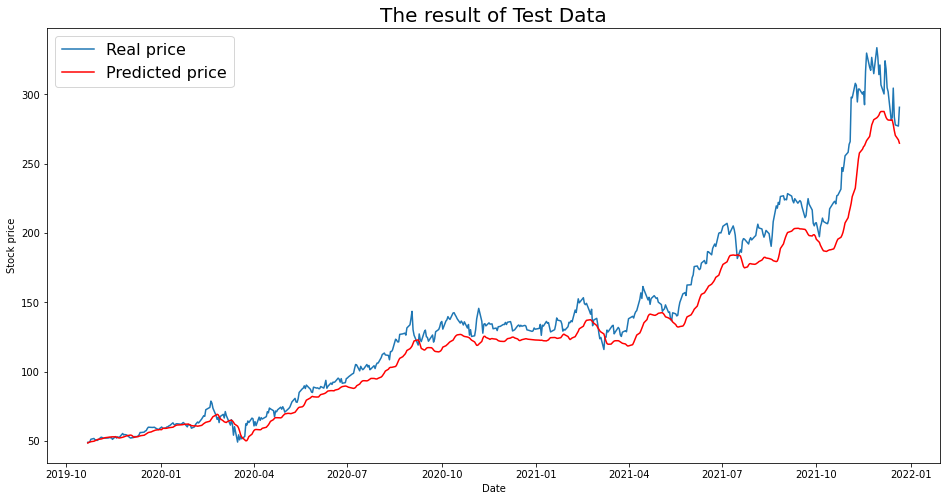

-- Test RMSE --  17.68972128970615


In [ ]:
test_generator139 = tf.keras.models.load_model('gen_model_3_5_139.h5')
predicted_test_data = eval_op(test_generator139, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

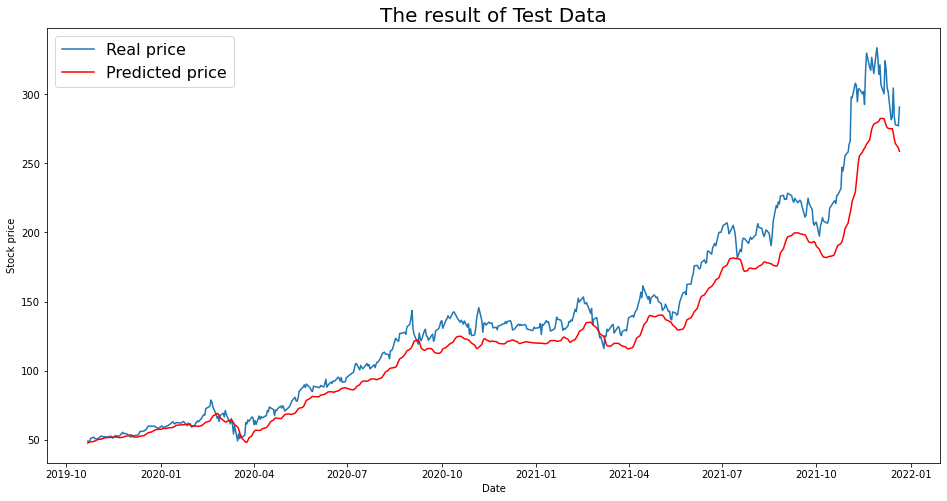

-- Test RMSE --  19.815766529902067


In [ ]:
test_generator119 = tf.keras.models.load_model('gen_model_3_5_119.h5')
predicted_test_data = eval_op(test_generator119, X_test)
plot_test_data(y_test, predicted_test_data,index_test)